In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from pathlib import Path
from ruamel import yaml
from pprint import pprint

from ipywidgets import interact

import h5py

from lib_lt.tools import recursive_read_attrs

from tqdm.notebook import tqdm

/home/carmelo/lense_thirring/lib_lt/tracker.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [166]:
import mpl_article_style as mpas

In [4]:
from scipy.ndimage import gaussian_filter

In [5]:
!ls /home/carmelo/lense_thirring/code/bh3/run

0000  0003  0006  0009	0012  0015  0018  0021	0024  0027  0030  0033
0001  0004  0007  0010	0013  0016  0019  0022	0025  0028  0031  0034
0002  0005  0008  0011	0014  0017  0020  0023	0026  0029  0032  0035


In [6]:
root = Path('/home/carmelo/lense_thirring/code/bh3')

data = [
    (27, 0),  # no mass
    (25, 0),  # nu = 0
    (28, 0),  # nu = 1
    (26, 0),  # nu = 3
    (26, 1),  # nu = 6
    (28, 1),  # nu = 8
    (26, 2),  # nu = 10
    (28, 2),  # nu = 12
    (29, 1),  # nu = 15
    (29, 0),  # nu = 20
]

data = [{'h5filename': root / f'run/{seq:04d}/bh_{run:04d}.h5'} for seq, run in data]

for D in tqdm(data):
    home_group = 'realtime'
    vortices = {}
    h5filename = D['h5filename']
    print(h5filename)
    
    conf = recursive_read_attrs(h5filename, 'configure')
    Gamma, nu = conf['globals']['Gamma'], conf['globals']['nu']
    
    with h5py.File(h5filename, 'r') as f:
        g = f[f"{home_group}/1"]
        x = g['x'][:]
        n = g['psiI'][:]**2 + g['psiR'][:]**2
        
        g = f[f'{home_group}/vortices']
        for key in g.keys():
            uid = int(key)
            vg = g[key]
            vx = {'time': vg['time'][:], 'coords': vg['coords'][:]}
            vortices[uid] = vx
            
    # a bunch of observables related to the two precessing vortices
    
    # I want v1 to be the upper one
    if vortices[1]['coords'][0, 1] > 0:
        v0 = vortices[0]['coords']
        v1 = vortices[1]['coords']
    else:
        v0 = vortices[1]['coords']
        v1 = vortices[0]['coords']

    L = min(len(v0), len(v1))
    v0 = v0[:L]
    v1 = v1[:L]

    v_cm = 0.5 * (v0 + v1)
    d = v1 - v0
    tv = vortices[0]['time'][:L]

    # print(np.all(vortices[0]['time'][:L] == vortices[1]['time'][:L]))

    dist = np.linalg.norm(d, axis=1)

    angle = np.unwrap(np.arctan2(d[:, 1], d[:, 0]))
    omega = np.gradient(angle, tv)
    omega = gaussian_filter(omega, 2)


    dx = np.diff(x).mean()

    v_cm_ix = len(x) // 2 + v_cm / dx

    nv = np.empty(tv.shape)

    for j, (ix, iy) in enumerate(v_cm_ix):
        loc = ((int(ix), int(ix), int(ix) + 1, int(ix) + 1), (int(iy), int(iy) + 1, int(iy), int(iy) + 1))
        nv[j] = n[j][loc].mean()
    
    to_D = ['tv', 'v0', 'v1', 'd', 'v_cm', 'dist', 'angle', 'omega', 'nv', 'conf', 'Gamma', 'nu']
    for name in to_D:
        exec(f"D['{name}'] = {name}")

/home/carmelo/lense_thirring/code/bh3/run/0027/bh_0000.h5
/home/carmelo/lense_thirring/code/bh3/run/0025/bh_0000.h5
/home/carmelo/lense_thirring/code/bh3/run/0028/bh_0000.h5
/home/carmelo/lense_thirring/code/bh3/run/0026/bh_0000.h5
/home/carmelo/lense_thirring/code/bh3/run/0026/bh_0001.h5
/home/carmelo/lense_thirring/code/bh3/run/0028/bh_0001.h5
/home/carmelo/lense_thirring/code/bh3/run/0026/bh_0002.h5
/home/carmelo/lense_thirring/code/bh3/run/0028/bh_0002.h5
/home/carmelo/lense_thirring/code/bh3/run/0029/bh_0001.h5
/home/carmelo/lense_thirring/code/bh3/run/0029/bh_0000.h5



In [119]:
rmin, rmax = 10, 40
R = conf['globals']['radius']

<IPython.core.display.Javascript object>


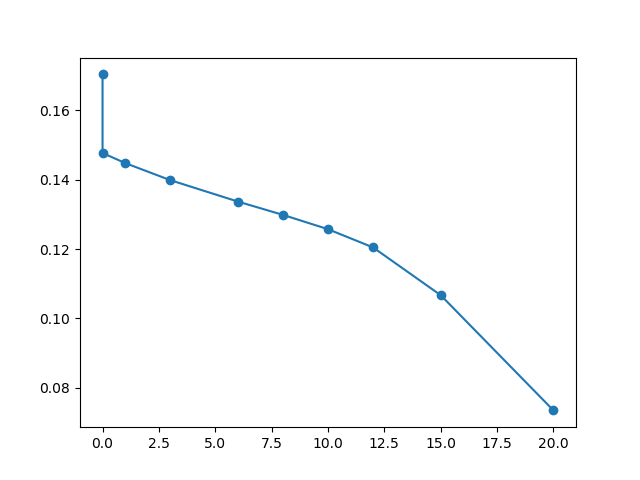

In [149]:
import lmfit

def precession(t, a, omega):
    x = -a * np.sin(omega * t)
    y = a * np.cos(omega * t)
    return np.stack([x, y], axis=0)

M = lmfit.Model(precession, independent_vars=['t'])
M.set_param_hint('a', min=0)
M.set_param_hint('omega', min=0)

for D in data:
    from_D = [
        'tv', 'dist', 'nv', 'omega', 'Gamma', 'nu',
        'v0', 'v1', 'v_cm', 'd'
    ]

    for name in from_D:
        exec(f"{name} = D['{name}']")
    
    wh = tv < 50

    p0 = M.make_params(a=D['dist'][0], omega=D['omega'][wh].mean())
    res = M.fit(d[wh].T, p0, t=tv[wh])
#     print(res.fit_report())

    D['fitted_omega'] = res.params['omega'].value
    D['fitted_omega_err'] = res.params['omega'].stderr
    
fig, ax = plt.subplots()

nu = [D['nu'] for D in data]
fitted_omega = [D['fitted_omega'] for D in data]
ax.plot(nu, fitted_omega, 'o-')

<IPython.core.display.Javascript object>


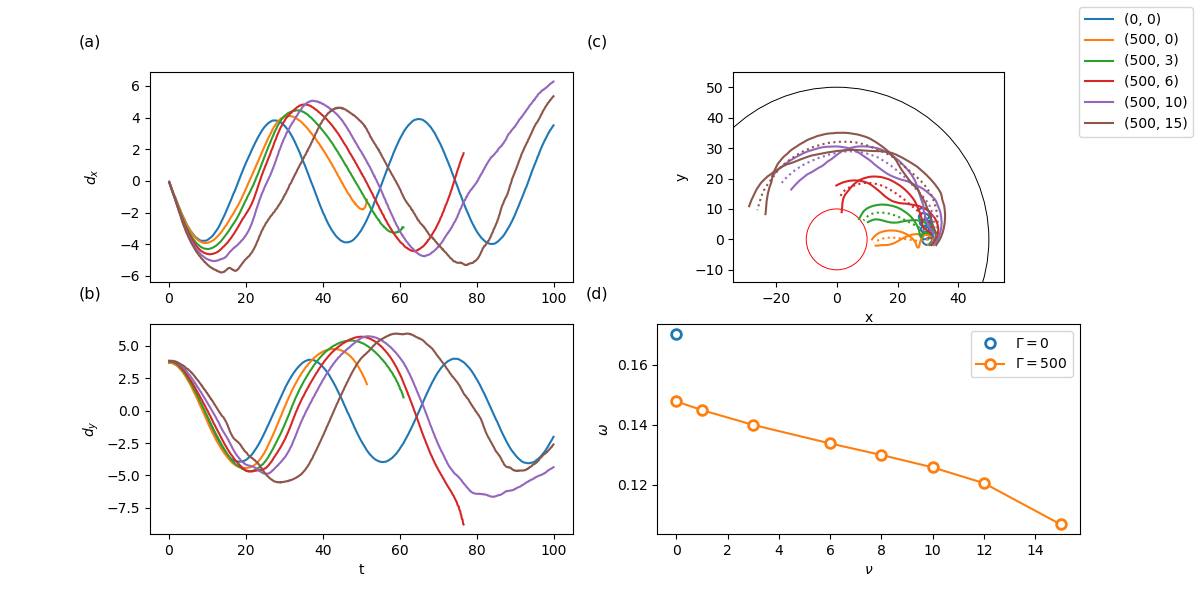

In [180]:
to_plot = [data[0], data[1], data[3], data[4], data[6], data[-2]]

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes, _axes = axes.T
ax0, ax1 = axes

ax0.get_shared_x_axes().join(ax0, ax1)

ax, ax_omega = _axes
# gs = _axes[0].get_gridspec()
# for _ax in _axes:
#     _ax.remove()
# ax = fig.add_subplot(gs[:, 1])
# ax.set_aspect(1)

# for D in data:
for uix, D in enumerate(to_plot):
    
    from_D = [
        'tv', 'dist', 'nv', 'omega', 'Gamma', 'nu',
        'v0', 'v1', 'v_cm', 'd', 'fitted_omega'
    ]
    
    for name in from_D:
        exec(f"{name} = D['{name}']")
    
    l, = ax.plot(*v0.T, label=(Gamma, nu))
    col = l.get_color()
    ax.plot(*v1.T, color=col)
    ax.plot(*v_cm.T, color=col, ls=':')
        
    wh = tv < 50
            
    for j, _ax in enumerate([ax0, ax1]):
        _ax.plot(tv, d[:, j])
#         _ax.plot(tv[wh], fitted[j], ls='--', color=l.get_color())
    

#     ax_omega.plot(nu, fitted_omega, marker='o', color=col)
    

#     ax.plot(*v_cm.T)
    
ax.add_patch(Circle((0, 0), rmin, fc='none', ec='r', lw=0.7))
# ax.add_patch(Circle((0, 0), rmax, fc='none', ec='r', lw=0.7))
ax.add_patch(Circle((0, 0), R, fc='none', ec='k', lw=0.7))

ax.set_aspect(1)
ax.autoscale_view()

ax0.set_ylabel('$d_x$')
ax1.set_ylabel('$d_y$')
ax1.set_xlabel('t')
    
fig.legend(loc='upper right')
ax.set(
    xlim=(-34, None), ylim=(-14, None),
    xlabel='x', ylabel='y'
)

fig.align_ylabels([ax0, ax1])

nu = data[0]['nu']
f0 = data[0]['fitted_omega']

kw = dict(marker='o', ms=7, mfc='w', mew=2)

ax_omega.plot(nu, f0, ls='', **kw, label='$\Gamma = 0$')

nu = [D['nu'] for D in data if D['nu'] < 20 and D['Gamma'] > 0]
fitted_omega = [D['fitted_omega'] for D in data if D['nu'] < 20 and D['Gamma'] > 0]

ax_omega.plot(nu, fitted_omega, ls='-', **kw, label='$\Gamma = 500$')
ax_omega.set(xlabel='$\\nu$', ylabel="$\omega$")
ax_omega.legend()

mpas.label_subplots(axes=[ax0, ax1, ax, ax_omega])

fig.savefig('figures/scan_nu.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


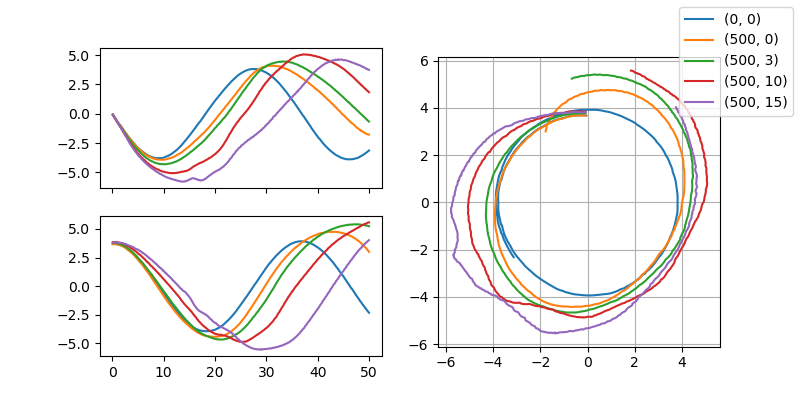

50.000000010270924 400
[[Model]]
    Model(precession)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 800
    # variables        = 2
    chi-square         = 7.32609582
    reduced chi-square = 0.00918057
    Akaike info crit   = -3750.53519
    Bayesian info crit = -3741.16596
[[Variables]]
    a:      3.84920990 +/- 0.00479076 (0.12%) (init = 3.678381)
    omega:  0.17035175 +/- 4.3034e-05 (0.03%) (init = 0.1700477)

50.000000010270924 400
[[Model]]
    Model(precession)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 800
    # variables        = 2
    chi-square         = 511.427579
    reduced chi-square = 0.64088669
    Akaike info crit   = -353.924590
    Bayesian info crit = -344.555367
[[Variables]]
    a:      4.14011063 +/- 0.04002770 (0.97%) (init = 3.678793)
    omega:  0.14763396 +/- 3.3429e-04 (0.23%) (init = 0.1362894)

50.000000010270924 400
[[Model]]
    M

In [116]:
# nu = 10
# D = data[6]

fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharex='col')
axes, _axes = axes.T
gs = _axes[0].get_gridspec()
for _ax in _axes:
    _ax.remove()
ax0 = fig.add_subplot(gs[:, 1])
ax0.set_aspect(1)

for D in [data[0], data[1], data[3], data[6], data[-2]]:
# for D in [data[0], data[6]]:


    tv = D['tv'][wh]
    d = D['d'][wh]
    
    print(tv.max(), len(tv))
    
   #     fitted = res.eval(a1=D['dist'], a2=D['dist'], omega=D['omega'], t=tv)
    
    
    
#     d = d - d[0]
    label = (D['Gamma'], D['nu'])


    for j, ax in enumerate(axes):
        l, = ax.plot(tv, d[:, j])
        
    ax0.plot(*d.T, label=label)
fig.legend()
ax0.grid()


<IPython.core.display.Javascript object>


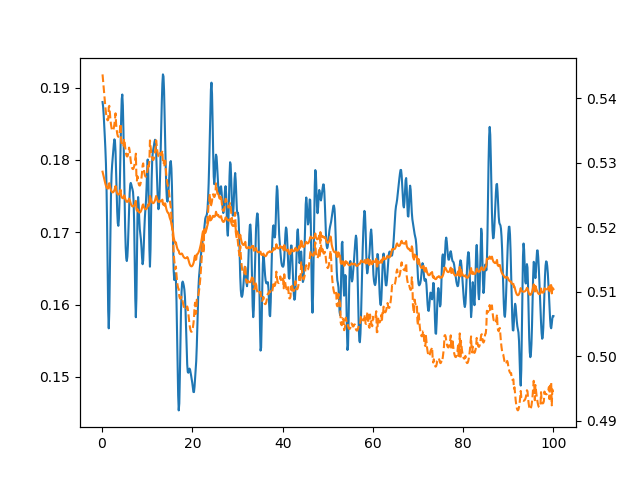

<IPython.core.display.Javascript object>


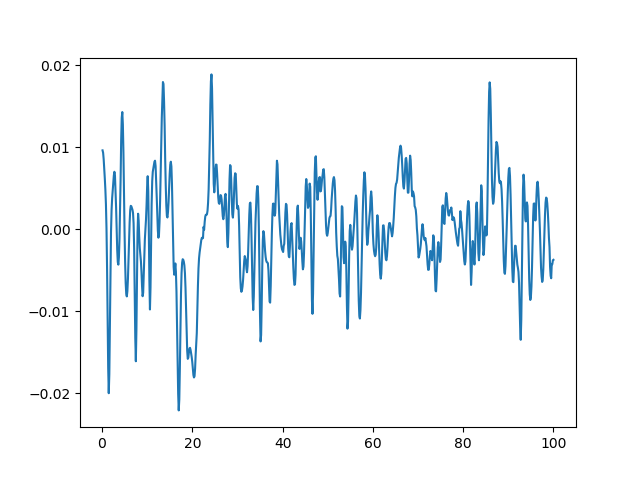

In [109]:
# theo. omega

D = data[0]

from_D = [
    'tv', 'dist', 'nv', 'omega', 'Gamma', 'nu',
]

for name in from_D:
    exec(f"{name} = D['{name}']")
    
inst_omega = 2 / dist

p0 = lmfit.Parameters()
p0.add('b', value=1)

def fcn(p0):
    b = p0['b'].value
    return omega - b * inst_omega

fig, ax = plt.subplots()

res = lmfit.minimize(fcn, p0)
b = res.params['b']

# ax.plot(omega, inst_omega, 'o')
ax.plot(tv, omega)
ax1 = plt.twinx(ax)
ax.plot(tv, b * inst_omega, 'C1')
ax1.plot(tv, inst_omega, 'C1--')

fig, ax = plt.subplots()
ax.plot(tv, omega - b * inst_omega)

In [79]:
res.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
b    0.3281     -inf      inf 0.0004247     True     None     None


In [ ]:
D